# Import qbiome

In [5]:
import qbiome
from qbiome.data_formatter import DataFormatter
from qbiome.quantizer import Quantizer
from qbiome.qnet_orchestrator import QnetOrchestrator
from qbiome.mask_checker import MaskChecker
from qbiome.forecaster import Forecaster
from qbiome.hypothesis import Hypothesis
from qbiome.qutil import customDataFormatter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
sns.set_theme()
plt.style.use('ggplot')

from qbiome.qutil import qplot
from qbiome.qutil import qsmooth

%load_ext autoreload
%autoreload 2
%reload_ext qbiome.qutil
%reload_ext qbiome.forecaster


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data and initialization

In [6]:
dirname = 'example_data/HC/'
data = dirname + 'hc_Phylum_GTDB_denoised_filtered_percent.csv'
meta = dirname + 'hc_metadata.csv'
BIOMES=None
#BIOMES=['Actinobacteriota', 'Bacteroidota', 'Firmicutes', 'Proteobacteria', 'Fusobacteriota']

data,property_map=customDataFormatter(data,meta,
                        META_PROP=['hc', 'HCZ', 'sex', 'hc_Birth',
           'HCZ_Birth', 'hc_Discharge', 'HCZ_Discharge',
           'HCZ_discharge_birth_difference', 'HCZ_Category',
           'HCZ_difference_Category', 'NEC', 'IVH', 'ROP', 'BPD', 'Infection',
           'total_Morbidities', 'Morbidity_Category', 'TIMPS score',
           'TIMPS z-score', 'TIMPS Category'],
                        COL_SELECT={"Samples": "sample_id", "PTID": "subject_id", "PMA":"week"},
                                      BIOMES=BIOMES)

data_=data.assign(source='gnd')
quantizer = Quantizer(num_levels=6)
qnet_orchestrator = QnetOrchestrator(quantizer)

quantized = quantizer.quantize_df(data)
features, label_matrix = quantizer.get_qnet_inputs(quantized)
dequantized = quantizer.dequantize_to_df(label_matrix)
dequantized_plot = quantizer.melt_into_plot_format(dequantized)
quantizer.fit_random_forest(data, dequantized_plot)

In [7]:
data

,sample_id,variable,value,subject_id,week
0,100001.c.062,Deferribacterota,0.000000,100001,34
1,100001.c.062,Methylomirabilota,0.000000,100001,34
2,100001.c.062,Bdellovibrionota,0.000000,100001,34
3,100001.c.062,Proteobacteria,66.657408,100001,34
4,100001.c.062,Firmicutes_A,0.000000,100001,34
...,...,...,...,...,...
3747,100091.c.053,MBNT15,0.495998,100091,31
3748,100091.c.053,Gemmatimonadota,0.056363,100091,31
3749,100091.c.053,Patescibacteria,0.000000,100091,31
3750,100091.c.053,Armatimonadota,0.000000,100091,31


In [8]:
BIOMES=list(data.variable.value_counts().index.values)
BIOMES

['Patescibacteria',
 'Firmicutes_C',
 'Chloroflexota',
 'unclassified_Bacteria',
 'Cyanobacteriota',
 'Nitrospirota',
 'Desulfobacterota',
 'MBNT15',
 'Verrucomicrobiota',
 'Campylobacterota',
 'Spirochaetota',
 'Proteobacteria',
 'Armatimonadota',
 'Acidobacteriota',
 'Deferribacterota',
 'Desulfuromonadota',
 'Myxococcota',
 'Crenarchaeota',
 'Gemmatimonadota',
 'Firmicutes_A',
 'Actinobacteriota',
 'UBP10',
 'Bdellovibrionota',
 'Bacteroidota',
 'Methylomirabilota',
 'Planctomycetota',
 'Firmicutes',
 'Fusobacteriota']

# Train qnet

In [9]:
%%time
NUMQ=1
for i in tqdm(np.arange(NUMQ)):
    qnet_orchestrator.train_qnet(
        features, label_matrix, alpha=0.3, min_samples_split=2, 
        out_fname=None)
    qnet_orchestrator.save_qnet('data1_phylum_'+str(i)+'.joblib')
    #qnet_orchestrator.load_qnet('data1.joblib')

100%|██████████| 1/1 [01:16<00:00, 76.94s/it]

CPU times: user 1min 6s, sys: 1.35 s, total: 1min 7s
Wall time: 1min 16s


# Generate tree files

In [10]:
outdirname = 'dotfiles_1_phylum_'
import os
if not os.path.isdir(outdirname):
    os.makedirs(outdirname)
for f in os.listdir(outdirname):
    os.remove(os.path.join(outdirname, f))    
qnet_orchestrator.export_qnet_tree_dotfiles(outdirname)

! cd 'dotfiles_1_phylum_'; for i in `ls *dot`; do dot -Tpng $i -o ${i/dot/png}; done >& /dev/null

-rw-rw-r--. 1 ishanu ishanu 147K May 19 11:18 dotfiles_1_phylum_/Firmicutes_32.png
-rw-rw-r--. 1 ishanu ishanu 139K May 19 11:18 dotfiles_1_phylum_/Firmicutes_C_35.png
-rw-rw-r--. 1 ishanu ishanu 131K May 19 11:19 dotfiles_1_phylum_/unclassified_Bacteria_32.png
ls: write error: Broken pipe


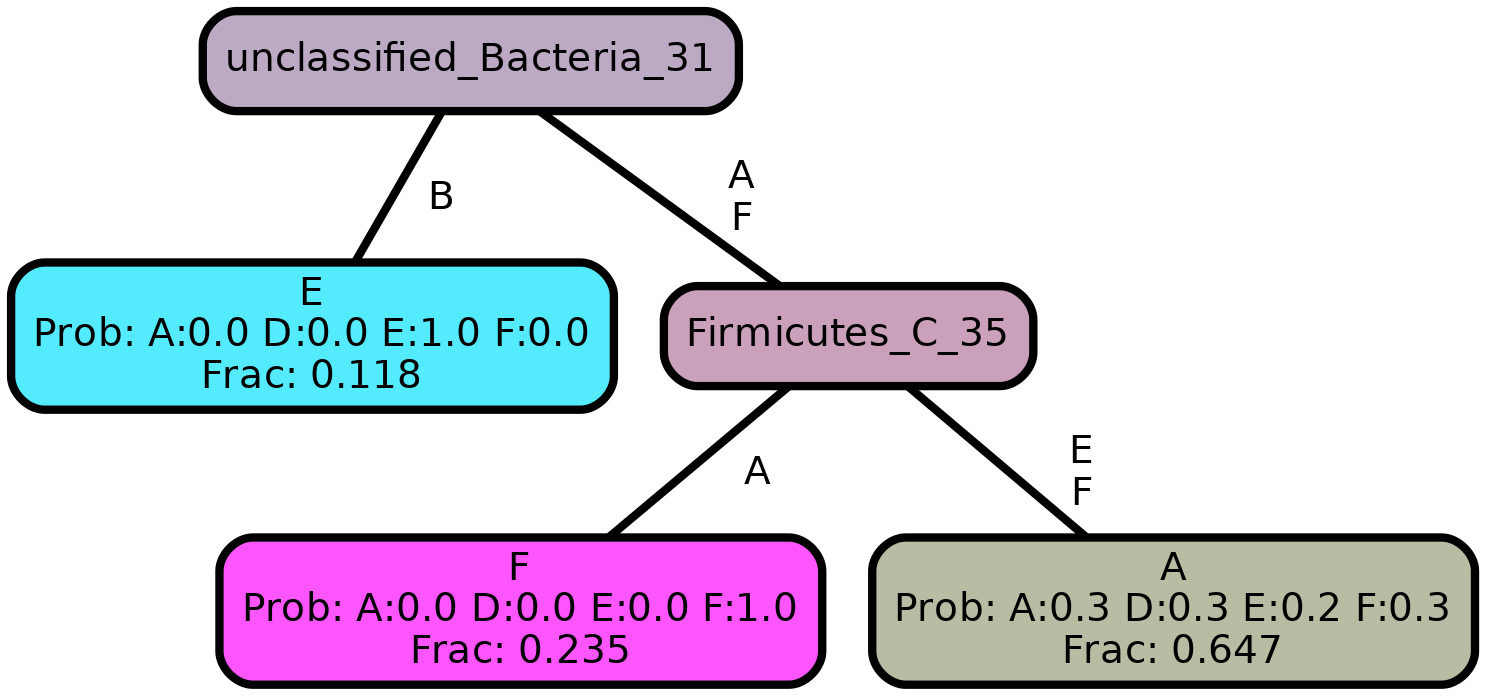

In [11]:
! ls -lhS dotfiles_1_phylum_/*png | head -n 3

from IPython.display import Image
from IPython.core.display import HTML 
Image(filename='dotfiles_1_phylum_/Proteobacteria_31.png')

# Generate hypotheses

In [30]:
hypothesis = Hypothesis(quantizer=quantizer, model_path=outdirname, 
                        detailed_labels=True)

hypothesis.causal_constraint = -2
hypothesis.no_self_loops = False

hypothesis.get(time_start=31, time_end=33)
hypothesis.to_dot('hypothesis_phylum_31_33_-2.dot')
hypothesis.hypotheses.sort_values('src')

100%|██████████| 28/28 [00:04<00:00,  6.55it/s]


,src,tgt,time_tgt,lomar,pvalue
21,Acidobacteriota,Desulfobacterota,33.0,8.069094e-03,0.000000e+00
53,Acidobacteriota,Chloroflexota,31.0,3.215437e-03,0.000000e+00
52,Acidobacteriota,Chloroflexota,33.0,3.139722e-03,2.655040e-67
23,Acidobacteriota,Myxococcota,33.0,8.061379e-03,0.000000e+00
24,Acidobacteriota,Myxococcota,31.0,-3.222766e-03,3.075458e-83
5,Acidobacteriota,Campylobacterota,31.0,-2.599850e-03,1.072054e-94
26,Acidobacteriota,Nitrospirota,31.0,1.989814e-02,0.000000e+00
13,Acidobacteriota,MBNT15,33.0,8.698758e-03,0.000000e+00
36,Acidobacteriota,Desulfuromonadota,31.0,-1.268608e-03,1.004661e-89
56,Acidobacteriota,Fusobacteriota,33.0,-5.379118e-03,6.859742e-27


# Forecast microbiome evolution

In [13]:
%%time
# forecast from time SW
SW=29
qnet_orchestrator = QnetOrchestrator(quantizer)
qnet_orchestrator.load_qnet('data1_phylum_'+str(i)+'.joblib')
forecaster = Forecaster(qnet_orchestrator)
# can specify an end week or default to the max end week in the data
forecasted_ = forecaster.forecast_data(
    label_matrix, 
    start_week=SW).assign(source='forecasted')
    

CPU times: user 2min 26s, sys: 407 ms, total: 2min 27s
Wall time: 2min 27s


In [14]:
label_matrix.shape

(39, 532)

In [15]:
#forecasted_dict[0]
DF=forecasted_
SUBJECTS=DF.subject_id.value_counts().index.values
DF

,subject_id,variable,week,value,source
0,100001,Acidobacteriota,24,NaN,forecasted
1,100002,Acidobacteriota,24,NaN,forecasted
2,100003,Acidobacteriota,24,NaN,forecasted
3,100004,Acidobacteriota,24,NaN,forecasted
4,100005,Acidobacteriota,24,NaN,forecasted
...,...,...,...,...,...
20743,100078,unclassified_Bacteria,43,1.962934,forecasted
20744,100083,unclassified_Bacteria,43,1.962934,forecasted
20745,100084,unclassified_Bacteria,43,1.962934,forecasted
20746,100090,unclassified_Bacteria,43,1.663956,forecasted


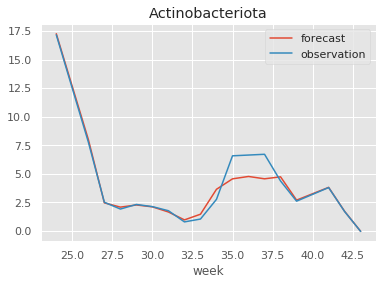

In [16]:
DF_pop=DF.groupby(['variable','week']).mean().reset_index().drop('subject_id',axis=1)
DF_data=data.groupby(['variable','week']).mean().reset_index().drop('subject_id',axis=1)

DF_pop_smooth=qsmooth(DF_pop,index='week',
                      columns='variable',
                      normalize=False,alpha=.99,
                      interpolate=False,lowess_fraction=.3)

#DF_data_smooth
DF_data_smooth=qsmooth(DF_data,index='week',
                       columns='variable',
                       normalize=False,alpha=.99,
                       interpolate=False,lowess_fraction=.3)


ax=DF_pop_smooth.Actinobacteriota.plot(label='forecast')
DF_data_smooth.Actinobacteriota.plot(ax=ax,label='observation')
ax.set_title('Actinobacteriota')
ax.legend();

In [17]:
data.subject_id.value_counts().index.values

array([100052, 100041, 100001, 100004, 100012, 100011, 100003, 100016,
       100051, 100058, 100063, 100064, 100014, 100053, 100050, 100005,
       100054, 100015, 100068, 100055, 100083, 100002, 100057, 100069,
       100075, 100061, 100078, 100084, 100066, 100062, 100060, 100036,
       100010, 100091, 100090, 100076, 100070, 100065, 100056])

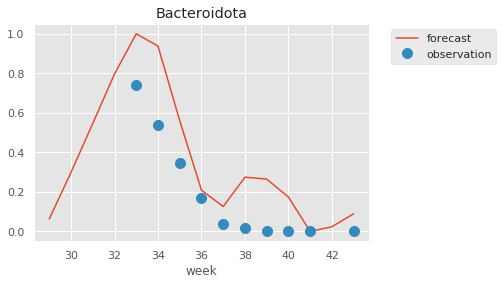

In [18]:
SID=100091
DF_pop=DF[DF.subject_id==SID].groupby(['variable','week']).mean().reset_index().drop('subject_id',axis=1)
DF_data=data[DF.subject_id==SID].groupby(['variable','week']).mean().reset_index().drop('subject_id',axis=1)
DF_pop_smooth=qsmooth(DF_pop,index='week',
                      columns='variable',
                      normalize=True,alpha=.99,
                      interpolate=False,lowess_fraction=.4)

#DF_data_smooth
DF_data_smooth=qsmooth(DF_data,index='week',
                       columns='variable',
                       normalize=True,alpha=.99,
                       interpolate=False,lowess_fraction=.6)

var='Bacteroidota'
ax=DF_pop_smooth[var].plot(label='forecast')
DF_data_smooth[var].plot(ax=ax,style='o',ms=10,label='observation')
ax.set_title('Bacteroidota')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left');

## Forecast data for a new patient

+ Read in new data, quantize, and forecast

,week,variable,value
0,29,Patescibacteria,0.375669
1,29,Firmicutes_C,0.339261
2,29,Chloroflexota,0.705065
3,29,unclassified_Bacteria,0.045124
4,29,Cyanobacteriota,0.318019
5,29,Nitrospirota,0.577127
6,29,Desulfobacterota,0.294050
7,29,MBNT15,0.617159
8,29,Verrucomicrobiota,0.092348
9,29,Campylobacterota,0.981475


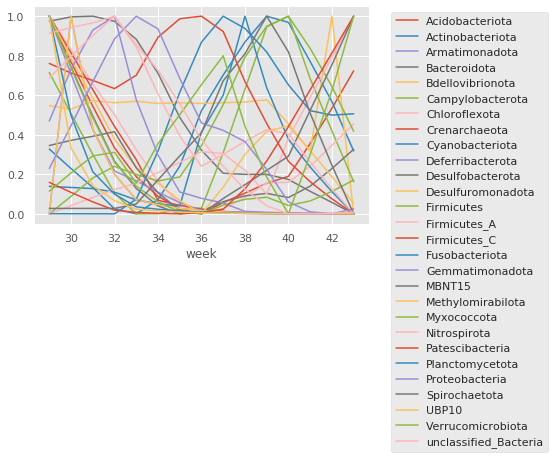

In [22]:
new_subject = pd.DataFrame({
    'week': [SW] * len(BIOMES),
    'variable': BIOMES,
    'value': np.random.rand(len(BIOMES))
})

new_subject.to_csv('example_data/single_patient_dummy/new_subject.csv',index=None)
new_subject=pd.read_csv('example_data/single_patient_dummy/new_subject.csv')
display(new_subject)

new_subject_quantized = quantizer.quantize_new_subject(new_subject, subject_id=12345)
_, new_subject_matrix = quantizer.get_qnet_inputs(new_subject_quantized)
new_subject_forecasted = forecaster.forecast_data(
    new_subject_matrix, 
    start_week=29, subject_id=[12345]
)

df_=qsmooth(new_subject_forecasted.drop('subject_id',axis=1),index='week',
                    columns='variable',
                    interpolate=False,alpha=.5,
                    lowess_fraction=0.5,normalize=True)

ax=df_.plot()
ax.legend( bbox_to_anchor=(1.05, 1), loc='upper left')

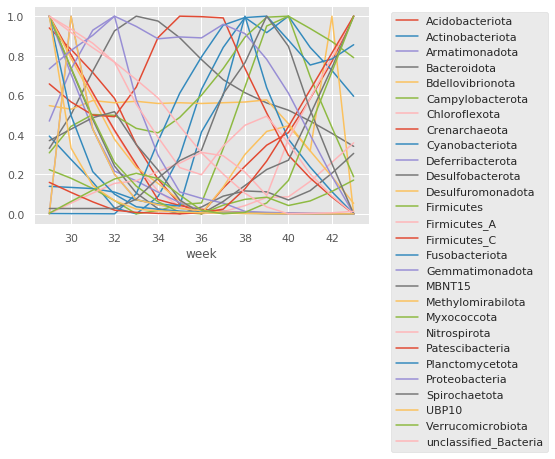

In [23]:
new_subject=pd.read_csv('example_data/single_patient_dummy/new_subject_001.csv')
#display(new_subject)

new_subject_quantized = quantizer.quantize_new_subject(new_subject, subject_id='1011')
_, new_subject_matrix = quantizer.get_qnet_inputs(new_subject_quantized)
new_subject_forecasted = forecaster.forecast_data(
    new_subject_matrix, 
    start_week=29, subject_id=['1011']
)
df_=qsmooth(new_subject_forecasted.drop('subject_id',axis=1),index='week',
                    columns='variable',
                    interpolate=False,alpha=.5,
                    lowess_fraction=0.5,normalize=True)

ax=df_.plot()
ax.legend( bbox_to_anchor=(1.05, 1), loc='upper left')

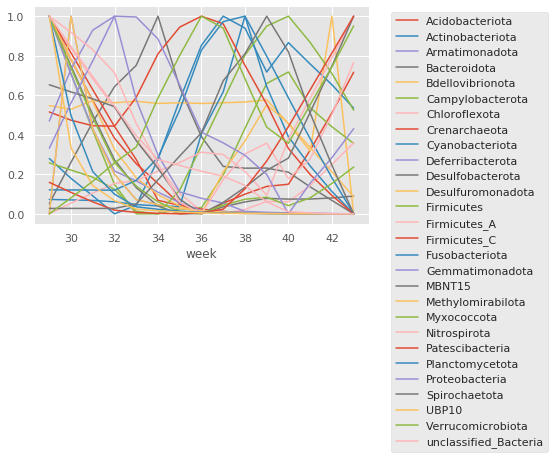

In [24]:
new_subject=pd.read_csv('example_data/single_patient_dummy/new_subject_002.csv')
#display(new_subject)

new_subject_quantized = quantizer.quantize_new_subject(new_subject, subject_id='1012')
_, new_subject_matrix = quantizer.get_qnet_inputs(new_subject_quantized)
new_subject_forecasted = forecaster.forecast_data(
    new_subject_matrix, 
    start_week=29, subject_id=['1012']
)
df_=qsmooth(new_subject_forecasted.drop('subject_id',axis=1),index='week',
                    columns='variable',
                    interpolate=False,alpha=.5,
                    lowess_fraction=0.5,normalize=True)

ax=df_.plot()
ax.legend( bbox_to_anchor=(1.05, 1), loc='upper left')

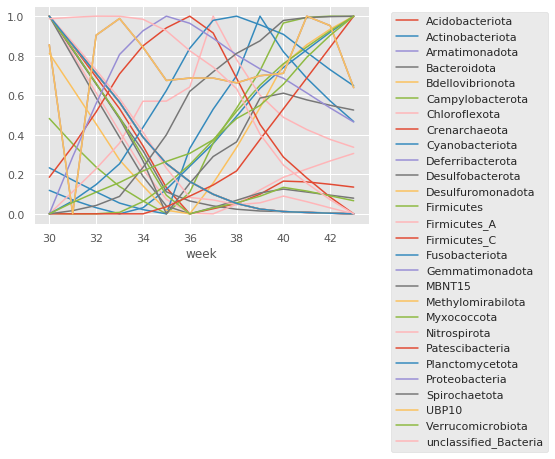

In [25]:
new_subject=data[(data.subject_id==100001) & (data.week<32)].drop('sample_id',axis=1).reset_index(drop=True)

new_subject_quantized = quantizer.quantize_new_subject(new_subject, subject_id='1011')
_, new_subject_matrix = quantizer.get_qnet_inputs(new_subject_quantized)
new_subject_forecasted = forecaster.forecast_data(
    new_subject_matrix, 
    start_week=33,end_week=40, subject_id=['1013']
)
df_=qsmooth(new_subject_forecasted.drop('subject_id',axis=1),index='week',
                    columns='variable',
                    interpolate=False,alpha=.5,
                    lowess_fraction=0.6,normalize=True)

ax=df_.plot()
ax.legend( bbox_to_anchor=(1.05, 1), loc='upper left')

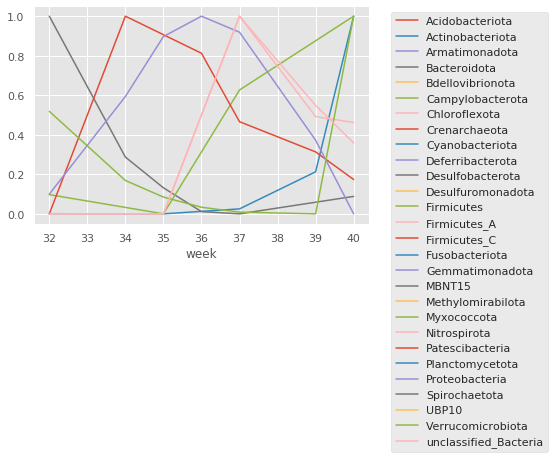

In [26]:
df_original_data=data[(data.subject_id==100001) & (data.week>=32)].drop('sample_id',axis=1).reset_index(drop=True)

df_=qsmooth(df_original_data.drop('subject_id',axis=1),index='week',
                    columns='variable',
                    interpolate=False,alpha=.5,
                    lowess_fraction=0.6,normalize=True)

ax=df_.plot()
ax.legend( bbox_to_anchor=(1.05, 1), loc='upper left')